In [1]:
import os
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Data directory on Tale's drive
data_dir = '/content/drive/MyDrive/6.819_data'

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
!pip install tqdm
from tqdm.notebook import tqdm
import os
import copy
import pandas as pd
import PIL 
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import skimage
  
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")
    print("You may want to try to use the GPU in Google Colab by clicking in:")
    print("Runtime > Change Runtime type > Hardware accelerator > GPU.")

Using the GPU!


In [4]:
normalize = transforms.Normalize(mean=[0.45271412, 0.45271412, 0.45271412],
                                     std=[0.33165374, 0.33165374, 0.33165374])
train_transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(90),
    # random brightness and random contrast
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    normalize
])

val_transformer = transforms.Compose([
#     transforms.Resize(224),
#     transforms.CenterCrop(224),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

In [7]:
## Another way to process the dataset based on the txt split file
## Consistent with the original paper

batchsize=32
def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data


class CovidCTDataset(Dataset):
    def __init__(self, root_dir, txt_COVID, txt_NonCOVID, transform=None):
        """
        Args:
            txt_path (string): Path to the txt file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        File structure:
        - root_dir
            - COVID
                - img1.png
                - img2.png
                - ......
            - NonCOVID
                - img1.png
                - img2.png
                - ......
        """
        self.root_dir = root_dir
        self.txt_path = [txt_COVID,txt_NonCOVID]
        self.classes = ['COVID', 'NonCOVID']
        self.num_cls = len(self.classes)
        self.img_list = []
        for c in range(self.num_cls):
            cls_list = [[os.path.join(self.root_dir,self.classes[c],item), c] for item in read_txt(self.txt_path[c])]
            self.img_list += cls_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx][0]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        sample = {'img': image,
                  'label': int(self.img_list[idx][1])}
        return sample

In [8]:
file_cov = open('drive/MyDrive/6.819_data/train_COVID.txt', 'w')

for file_name in os.listdir('drive/MyDrive/6.819_data/train/COVID/'):
  file_cov.write(str(file_name) + os.linesep)

In [10]:
file_cov = open('drive/MyDrive/6.819_data/train_NON_COVID.txt', 'w')

for file_name in os.listdir('drive/MyDrive/6.819_data/train/NonCOVID/'):
  file_cov.write(str(file_name) + os.linesep)

In [12]:
file_cov = open('drive/MyDrive/6.819_data/val_COVID.txt', 'w')

for file_name in os.listdir('drive/MyDrive/6.819_data/val/COVID/'):
  file_cov.write(str(file_name) + os.linesep)

In [13]:
file_cov = open('drive/MyDrive/6.819_data/val_NON_COVID.txt', 'w')

for file_name in os.listdir('drive/MyDrive/6.819_data/val/NonCOVID/'):
  file_cov.write(str(file_name) + os.linesep)

In [14]:
file_cov = open('drive/MyDrive/6.819_data/test_COVID.txt', 'w')

for file_name in os.listdir('drive/MyDrive/6.819_data/test/COVID/'):
  file_cov.write(str(file_name) + os.linesep)

In [76]:
file_ncov = open('drive/MyDrive/6.819_data/test_NON_COVID.txt', 'w')

for file_name in os.listdir('drive/MyDrive/6.819_data/test/NonCOVID/'):
  file_ncov.write(str(file_name) + os.linesep)

In [84]:
# rm drive/MyDrive/6.819_data/test_NON_COVID.txt

In [90]:
ls drive/MyDrive/6.819_data/

test/               train/               val/
test_COVID.txt      train_COVID.txt      val_COVID.txt
test_NON_COVID.txt  train_NON_COVID.txt  val_NON_COVID.txt


In [8]:
trainset = CovidCTDataset(root_dir=data_dir+'/train',
                          txt_COVID='drive/MyDrive/6.819_data/train_COVID.txt',
                          txt_NonCOVID='drive/MyDrive/6.819_data/train_NON_COVID.txt',
                          transform= train_transformer)
valset = CovidCTDataset(root_dir=data_dir+'/val',
                          txt_COVID='drive/MyDrive/6.819_data/val_COVID.txt',
                          txt_NonCOVID='drive/MyDrive/6.819_data/val_NON_COVID.txt',
                          transform= val_transformer)
testset = CovidCTDataset(root_dir=data_dir+'/test',
                          txt_COVID='drive/MyDrive/6.819_data/test_COVID.txt',
                          txt_NonCOVID='drive/MyDrive/6.819_data/test_NON_COVID.txt',
                          transform= val_transformer)
print(trainset.__len__())
print(valset.__len__())
print(testset.__len__())

train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)

1678
149
71


In [9]:
alpha = None
## alpha is None if mixup is not used
alpha_name = f'{alpha}'
device = 'cuda'

def make_optimizer(model, learning_rate, print_parameters=False):
    # Get all the parameters
    params_to_update = model.parameters()
    if print_parameters:
      print("Params to learn:")
      for name, param in model.named_parameters():
          if param.requires_grad == True:
              print("\t",name)

 
    optimizer = optim.SGD(params_to_update, lr=learning_rate, momentum=0.9)
    return optimizer

In [10]:
### train function modified from problem sets
def train_model(model, optimizer, epoch, save_dir = "", save_all_epochs=False):
    '''
    model: The NN to train
    dataloaders: A dictionary containing at least the keys 
                 'train','val' that maps to Pytorch data loaders for the dataset
    criterion: The Loss function
    optimizer: The algorithm to update weights 
               (Variations on gradient descent)
    num_epochs: How many epochs to train for
    save_dir: Where to save the best model weights that are found, 
              as they are found. Will save to save_dir/weights_best.pt
              Using None will not write anything to disk
    save_all_epochs: Whether to save weights for ALL epochs, not just the best
                     validation error epoch. Will save to save_dir/weights_e{#}.pt
    '''
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                data_loader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                data_loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # TQDM has nice progress bars
            for batch_index, batch_samples in enumerate(data_loader):
        
                # move data to device
                inputs, labels = batch_samples['img'].to(device), batch_samples['label'].to(device) 

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    criterion = nn.CrossEntropyLoss()
                    loss = criterion(outputs, labels)

                    # torch.max outputs the maximum value, and its index
                    # Since the input is batched, we take the max along axis 1
                    # (the meaningful outputs)
                    _, preds = torch.max(outputs, 1)

                    # backprop + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects.double() / len(data_loader.dataset)
            

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'train':
                train_acc_history.append(epoch_acc)
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if save_all_epochs:
                torch.save(model.state_dict(), os.path.join(save_dir, f'weights_{epoch}.pt'))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # save and load best model weights
    torch.save(best_model_wts, os.path.join(save_dir, 'weights_best_val_acc.pt'))
    torch.save(model.state_dict(), os.path.join(save_dir, 'weights_last.pt'.format(epoch)))
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history

In [11]:
def initialize_model(model_name, num_classes, resume_from = None, use_pretrained = False):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    # The model (nn.Module) to return
    model_ft = None
    # The input image is expected to be (input_size, input_size)
    input_size = 0
    
    # By default, all parameters will be trained (useful when you're starting from scratch)
    # Within this function you can set .requires_grad = False for various parameters, if you
    # don't want to learn them

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "resnet50":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        # if use_pretrained:
        #   print('pretrained model')
        #   for param in model_ft.features.parameters():
        #     param.requires_grad = False
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    else:
        raise Exception("Invalid model name!")
    
    if resume_from is not None:
        print("Loading weights from %s" % resume_from)
        model_ft.load_state_dict(torch.load(resume_from))
    
    return model_ft, input_size

In [12]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet]
# You can add your own, or modify these however you wish!
model_name = 'resnet50'

# Number of classes in the dataset, normal, benign, malignant
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Shuffle the input data?
shuffle_datasets = True

# Number of epochs to train for 
num_epochs = 20

# Learning rate
learning_rate = 0.008

### IO
# Path to a model file to use to start weights at
resume_from = None

# Whether to use a pretrained model, trained for classification in Imagenet-1k 
pretrained = True

# Save all epochs so that you can select the model from a particular epoch
save_all_epochs = False

# Whether to use early stopping (load the model with best accuracy), or not
early_stopping = True

# Directory to save weights to
# save_dir = models_dir + '/trained_model_1'
# os.makedirs(save_dir, exist_ok=True)

In [13]:
def evaluate(model, data_loader, is_labelled = False, generate_labels = True, k = 5):
    # If is_labelled, we want to compute loss, top-1 accuracy and top-5 accuracy
    # If generate_labels, we want to output the actual labels
    # Set the model to evaluate mode
    model.eval()
    running_loss = 0
    running_top1_correct = 0
    running_top5_correct = 0
    predicted_labels = []
    gt_labels = []

    # Iterate over data.
    # TQDM has nice progress bars
    for batch_index, batch_samples in enumerate(data_loader):
        inputs, labels = batch_samples['img'].to(device), batch_samples['label'].to(device) 
        tiled_labels = torch.stack([labels.data for i in range(k)], dim=1) 
        # Makes this to calculate "top 5 prediction is correct"
        # [[label1 label1 label1 label1 label1], [label2 label2 label2 label label2]]

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            # Get model outputs and calculate loss
            outputs = model(inputs)
            criterion = nn.CrossEntropyLoss()
            if is_labelled:
                loss = criterion(outputs, labels)

            # torch.topk outputs the maximum values, and their indices
            # Since the input is batched, we take the max along axis 1
            # (the meaningful outputs)
            _, preds = torch.topk(outputs, k=k, dim=1)
            if generate_labels:
                # We want to store these results
                nparr = preds.cpu().detach().numpy()
                predicted_labels.extend([list(nparr[i]) for i in range(len(nparr))])
                gt_labels.extend(np.array(labels.cpu()))

        if is_labelled:
            # statistics
            running_loss += loss.item() * inputs.size(0)
            # Check only the first prediction
            running_top1_correct += torch.sum(preds[:, 0] == labels.data)
            # Check all 5 predictions
            running_top5_correct += torch.sum(preds == tiled_labels)
        else:
            pass

    # Only compute loss & accuracy if we have the labels
    if is_labelled:
        epoch_loss = float(running_loss / len(data_loader.dataset))
        epoch_top1_acc = float(running_top1_correct.double() / len(data_loader.dataset))
        epoch_top5_acc = float(running_top5_correct.double() / len(data_loader.dataset))
    else:
        epoch_loss = None
        epoch_top1_acc = None
        epoch_top5_acc = None
    
    # Return everything
    return epoch_loss, epoch_top1_acc, gt_labels, predicted_labels

In [14]:
def get_eval_results(model, data_loader):
    model.eval()
    true_label_list = []
    outputs_list = []
    predicted_label_list = []
    original_image_list = []

    # TQDM has nice progress bars
    for batch_index, batch_samples in enumerate(data_loader):
        inputs, labels = batch_samples['img'].to(device), batch_samples['label'].to(device) 
        with torch.set_grad_enabled(False):
            # Get model outputs and calculate loss
            outputs = model(inputs)
            true_label_list.append(labels)
            original_image_list.append(inputs)
            outputs_list.append(outputs)
            _, preds = torch.topk(outputs, k=1, dim=1)
            predicted_label_list.append(preds)
    return torch.concat(true_label_list).unsqueeze(-1).cpu().numpy(), \
           torch.concat(predicted_label_list).cpu().numpy(), \
           torch.softmax(torch.concat(outputs_list), dim=1).cpu().numpy(), \
           torch.concat(original_image_list).cpu().numpy()

In [15]:
from sklearn.metrics import roc_auc_score, f1_score

ResNET50

In [105]:
test_acc, test_f1, test_auc = [], [], []

for i in range(2):
    model_1, input_size = initialize_model(model_name = 'resnet50', num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)
    model_1 = model_1.to(device)

    optimizer_1 = make_optimizer(model_1, learning_rate)
    trained_model_1, validation_history_1, train_history_1 = train_model(model_1, optimizer_1, num_epochs)

    # Load your final model, that we will use for the rest of the PSET.
    if early_stopping:
        weights_file = '' + 'weights_best_val_acc.pt'
    else:
        weights_file = '' + 'weights_last.pt'

    model_1, _ = initialize_model(model_name = model_name, num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)

    # Move the model to the gpu if needed
    model_1 = model_1.to(device)

    # Load weights for model_yours
    model_1.load_state_dict(torch.load(weights_file))

    # Get data on the validation set

    val_loss_yours, val_top1_yours, _, val_labels_yours = evaluate(model_1, val_loader, is_labelled = True, generate_labels = True, k = 1)
    # Get predictions for the test set
    test_loss_yours, test_top1_yours, _, test_labels_yours = evaluate(model_1, test_loader, is_labelled = True, generate_labels = True, k = 1)

    test_acc.append(test_top1_yours)

    print("Our Trained model: ")
    print("Val Top-1 Accuracy: {}".format(val_top1_yours))
    print("Test Top-1 Accuracy: {}".format(test_top1_yours))

    y_label, y_pred, outputs, inputs =  get_eval_results(model_1, test_loader)
    test_f1.append(f1_score(y_label, y_pred))
    test_auc.append(roc_auc_score(y_label, outputs[:, 1]))

    print("f1 score is :", f1_score(y_label, y_pred))
    print("AUC score is ", roc_auc_score(y_label, outputs[:, 1]))

Epoch 1/20
----------
train Loss: 0.8448 Acc: 0.6859
val Loss: 1.2276 Acc: 0.4161
Epoch 2/20
----------
train Loss: 0.5705 Acc: 0.7521
val Loss: 0.6062 Acc: 0.6040
Epoch 3/20
----------
train Loss: 0.4338 Acc: 0.8045
val Loss: 0.5032 Acc: 0.7315
Epoch 4/20
----------
train Loss: 0.3697 Acc: 0.8242
val Loss: 0.5814 Acc: 0.6711
Epoch 5/20
----------
train Loss: 0.3168 Acc: 0.8611
val Loss: 0.5110 Acc: 0.7651
Epoch 6/20
----------
train Loss: 0.2543 Acc: 0.8951
val Loss: 0.4311 Acc: 0.8121
Epoch 7/20
----------
train Loss: 0.1924 Acc: 0.9082
val Loss: 0.4778 Acc: 0.7248
Epoch 8/20
----------
train Loss: 0.2022 Acc: 0.9052
val Loss: 0.4072 Acc: 0.8121
Epoch 9/20
----------
train Loss: 0.1968 Acc: 0.9166
val Loss: 0.3805 Acc: 0.8054
Epoch 10/20
----------
train Loss: 0.1506 Acc: 0.9392
val Loss: 0.6579 Acc: 0.6913
Epoch 11/20
----------
train Loss: 0.1551 Acc: 0.9315
val Loss: 0.9076 Acc: 0.6309
Epoch 12/20
----------
train Loss: 0.1477 Acc: 0.9416
val Loss: 0.4707 Acc: 0.7785
Epoch 13/20
-

In [106]:
print(np.mean(test_acc), np.std(test_acc))
print(np.mean(test_f1), np.std(test_f1))
print(np.mean(test_auc), np.std(test_auc))

0.767605633802817 0.04929577464788732
0.7947530864197532 0.04475308641975306
0.8559113300492611 0.018472906403940892


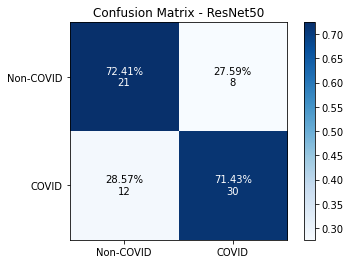

In [107]:
def plot_confusion_matrix(y_label, y_pred, title='Confusion matrix'):
    cf_matrix = np.zeros((2, 2))    
    for actual_value, predicted_value in zip(y_label, y_pred):
        cf_matrix[actual_value, predicted_value] += 1
    cf_matrix_per = cf_matrix / np.sum(cf_matrix, axis=1, keepdims=True)
    
    group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix_per.flatten()]
    labels = [f"{v2}\n{v1}" for v1, v2 in
              zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    fig, ax = plt.subplots()  
    im = ax.imshow(cf_matrix_per, cmap="Blues")
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, labels[i][j], ha="center", va="center", 
                            color='w' if cf_matrix_per[i, j] > 0.5 else 'black')
    
    ax.set_title(title)
    ax.set_xticks(np.arange(2))
    ax.set_yticks(np.arange(2))
    ax.xaxis.set_ticklabels(['Non-COVID', 'COVID'])
    ax.yaxis.set_ticklabels(['Non-COVID', 'COVID'])
    ax.figure.colorbar(im, ax=ax)

    plt.show()

  
plot_confusion_matrix(y_label, y_pred, 'Confusion Matrix - ResNet50')

ResNET18

In [108]:
test_acc, test_f1, test_auc = [], [], []

for i in range(2):
    model_1, input_size = initialize_model(model_name = 'resnet', num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)
    model_1 = model_1.to(device)

    optimizer_1 = make_optimizer(model_1, learning_rate)
    trained_model_1, validation_history_1, train_history_1 = train_model(model_1, optimizer_1, num_epochs)

    # Load your final model, that we will use for the rest of the PSET.
    if early_stopping:
        weights_file = '' + 'weights_best_val_acc.pt'
    else:
        weights_file = '' + 'weights_last.pt'

    model_1, _ = initialize_model(model_name = 'resnet', num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)

    # Move the model to the gpu if needed
    model_1 = model_1.to(device)

    # Load weights for model_yours
    model_1.load_state_dict(torch.load(weights_file))

    # Get data on the validation set

    val_loss_yours, val_top1_yours, _, val_labels_yours = evaluate(model_1, val_loader, is_labelled = True, generate_labels = True, k = 1)
    # Get predictions for the test set
    test_loss_yours, test_top1_yours, _, test_labels_yours = evaluate(model_1, test_loader, is_labelled = True, generate_labels = True, k = 1)

    test_acc.append(test_top1_yours)

    print("Our Trained model: ")
    print("Val Top-1 Accuracy: {}".format(val_top1_yours))
    print("Test Top-1 Accuracy: {}".format(test_top1_yours))

    y_label, y_pred, outputs, inputs =  get_eval_results(model_1, test_loader)
    test_f1.append(f1_score(y_label, y_pred))
    test_auc.append(roc_auc_score(y_label, outputs[:, 1]))

    print("f1 score is :", f1_score(y_label, y_pred))
    print("AUC score is ", roc_auc_score(y_label, outputs[:, 1]))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 1/20
----------
train Loss: 0.7477 Acc: 0.7104
val Loss: 2.1478 Acc: 0.4295
Epoch 2/20
----------
train Loss: 0.7659 Acc: 0.7175
val Loss: 1.1693 Acc: 0.6846
Epoch 3/20
----------
train Loss: 0.5130 Acc: 0.7896
val Loss: 0.5132 Acc: 0.7315
Epoch 4/20
----------
train Loss: 0.4290 Acc: 0.8099
val Loss: 0.5482 Acc: 0.7450
Epoch 5/20
----------
train Loss: 0.4482 Acc: 0.8063
val Loss: 0.4649 Acc: 0.7987
Epoch 6/20
----------
train Loss: 0.3463 Acc: 0.8492
val Loss: 0.5125 Acc: 0.7785
Epoch 7/20
----------
train Loss: 0.2841 Acc: 0.8754
val Loss: 0.4356 Acc: 0.7852
Epoch 8/20
----------
train Loss: 0.2408 Acc: 0.8945
val Loss: 0.6511 Acc: 0.7181
Epoch 9/20
----------
train Loss: 0.2318 Acc: 0.9046
val Loss: 0.4037 Acc: 0.8188
Epoch 10/20
----------
train Loss: 0.2041 Acc: 0.9052
val Loss: 0.7136 Acc: 0.7181
Epoch 11/20
----------
train Loss: 0.1989 Acc: 0.9088
val Loss: 0.3551 Acc: 0.8523
Epoch 12/20
----------
train Loss: 0.1864 Acc: 0.9154
val Loss: 0.3775 Acc: 0.8255
Epoch 13/20
-

In [109]:
print(np.mean(test_acc), np.std(test_acc))
print(np.mean(test_f1), np.std(test_f1))
print(np.mean(test_auc), np.std(test_auc))

0.7535211267605634 0.007042253521126751
0.7682456140350877 0.00508771929824553
0.8431855500821017 0.01888341543513955


DenseNET

In [110]:
test_acc, test_f1, test_auc = [], [], []

for i in range(5):
    model_1, input_size = initialize_model(model_name = 'densenet', num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)
    model_1 = model_1.to(device)

    optimizer_1 = make_optimizer(model_1, learning_rate)
    trained_model_1, validation_history_1, train_history_1 = train_model(model_1, optimizer_1, num_epochs)

    # Load your final model, that we will use for the rest of the PSET.
    if early_stopping:
        weights_file = '' + 'weights_best_val_acc.pt'
    else:
        weights_file = '' + 'weights_last.pt'

    model_1, _ = initialize_model(model_name = 'densenet', num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)

    # Move the model to the gpu if needed
    model_1 = model_1.to(device)

    # Load weights for model_yours
    model_1.load_state_dict(torch.load(weights_file))

    # Get data on the validation set

    val_loss_yours, val_top1_yours, _, val_labels_yours = evaluate(model_1, val_loader, is_labelled = True, generate_labels = True, k = 1)
    # Get predictions for the test set
    test_loss_yours, test_top1_yours, _, test_labels_yours = evaluate(model_1, test_loader, is_labelled = True, generate_labels = True, k = 1)

    test_acc.append(test_top1_yours)

    print("Our Trained model: ")
    print("Val Top-1 Accuracy: {}".format(val_top1_yours))
    print("Test Top-1 Accuracy: {}".format(test_top1_yours))

    y_label, y_pred, outputs, inputs =  get_eval_results(model_1, test_loader)
    test_f1.append(f1_score(y_label, y_pred))
    test_auc.append(roc_auc_score(y_label, outputs[:, 1]))

    print("f1 score is :", f1_score(y_label, y_pred))
    print("AUC score is ", roc_auc_score(y_label, outputs[:, 1]))

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

Epoch 1/20
----------
train Loss: 0.7535 Acc: 0.7128
val Loss: 0.7181 Acc: 0.5839
Epoch 2/20
----------
train Loss: 0.6228 Acc: 0.7539
val Loss: 0.6556 Acc: 0.6174
Epoch 3/20
----------
train Loss: 0.6807 Acc: 0.7247
val Loss: 7.6488 Acc: 0.6242
Epoch 4/20
----------
train Loss: 0.8150 Acc: 0.6990
val Loss: 2.5433 Acc: 0.6510
Epoch 5/20
----------
train Loss: 0.5565 Acc: 0.7533
val Loss: 0.6706 Acc: 0.6913
Epoch 6/20
----------
train Loss: 0.4866 Acc: 0.7855
val Loss: 1.1599 Acc: 0.5302
Epoch 7/20
----------
train Loss: 0.4815 Acc: 0.7950
val Loss: 1.2838 Acc: 0.5906
Epoch 8/20
----------
train Loss: 0.4800 Acc: 0.8051
val Loss: 0.5441 Acc: 0.7383
Epoch 9/20
----------
train Loss: 0.3579 Acc: 0.8397
val Loss: 0.5149 Acc: 0.7181
Epoch 10/20
----------
train Loss: 0.3618 Acc: 0.8451
val Loss: 0.4610 Acc: 0.7919
Epoch 11/20
----------
train Loss: 0.3071 Acc: 0.8689
val Loss: 0.4703 Acc: 0.7987
Epoch 12/20
----------
train Loss: 0.2697 Acc: 0.8796
val Loss: 0.6245 Acc: 0.7114
Epoch 13/20
-

In [111]:
print(np.mean(test_acc), np.std(test_acc))
print(np.mean(test_f1), np.std(test_f1))
print(np.mean(test_auc), np.std(test_auc))

0.743661971830986 0.06002049507792257
0.7583295918952899 0.06716631717378857
0.8236453201970443 0.04876985507210796


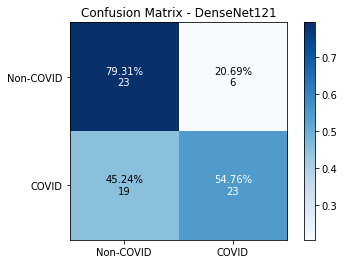

f1 score is : 0.647887323943662
AUC score is  0.7684729064039408


In [112]:
y_label, y_pred, outputs, inputs =  get_eval_results(model_1, test_loader)
plot_confusion_matrix(y_label, y_pred, 'Confusion Matrix - DenseNet121')
print("f1 score is :", f1_score(y_label, y_pred))
print("AUC score is ", roc_auc_score(y_label, outputs[:, 1]))

VGG HP

In [16]:
test_acc, test_f1, test_auc = [], [], []

for i in range(5):
    model_1, input_size = initialize_model(model_name = 'vgg', num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)
    model_1 = model_1.to(device)

    optimizer_1 = make_optimizer(model_1, learning_rate)
    trained_model_1, validation_history_1, train_history_1 = train_model(model_1, optimizer_1, num_epochs)

    # Load your final model, that we will use for the rest of the PSET.
    if early_stopping:
        weights_file = '' + 'weights_best_val_acc.pt'
    else:
        weights_file = '' + 'weights_last.pt'

    model_1, _ = initialize_model(model_name = 'vgg', num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)

    # Move the model to the gpu if needed
    model_1 = model_1.to(device)

    # Load weights for model_yours
    model_1.load_state_dict(torch.load(weights_file))

    # Get data on the validation set

    val_loss_yours, val_top1_yours, _, val_labels_yours = evaluate(model_1, val_loader, is_labelled = True, generate_labels = True, k = 1)
    # Get predictions for the test set
    test_loss_yours, test_top1_yours, _, test_labels_yours = evaluate(model_1, test_loader, is_labelled = True, generate_labels = True, k = 1)

    test_acc.append(test_top1_yours)

    print("Our Trained model: ")
    print("Val Top-1 Accuracy: {}".format(val_top1_yours))
    print("Test Top-1 Accuracy: {}".format(test_top1_yours))

    y_label, y_pred, outputs, inputs =  get_eval_results(model_1, test_loader)
    test_f1.append(f1_score(y_label, y_pred))
    test_auc.append(roc_auc_score(y_label, outputs[:, 1]))

    print("f1 score is :", f1_score(y_label, y_pred))
    print("AUC score is ", roc_auc_score(y_label, outputs[:, 1]))

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

Epoch 1/20
----------
train Loss: 0.2973 Acc: 0.8462
val Loss: 0.5817 Acc: 0.7047
Epoch 2/20
----------
train Loss: 0.2287 Acc: 0.8862
val Loss: 0.4660 Acc: 0.7718
Epoch 3/20
----------
train Loss: 0.1696 Acc: 0.9142
val Loss: 0.6598 Acc: 0.6577
Epoch 4/20
----------
train Loss: 0.1470 Acc: 0.9321
val Loss: 0.3145 Acc: 0.8859
Epoch 5/20
----------
train Loss: 0.1359 Acc: 0.9362
val Loss: 0.4384 Acc: 0.7852
Epoch 6/20
----------
train Loss: 0.1103 Acc: 0.9523
val Loss: 0.6255 Acc: 0.6980
Epoch 7/20
----------
train Loss: 0.1094 Acc: 0.9505
val Loss: 0.3896 Acc: 0.8389
Epoch 8/20
----------
train Loss: 0.1177 Acc: 0.9517
val Loss: 0.3133 Acc: 0.8389
Epoch 9/20
----------
train Loss: 0.0903 Acc: 0.9631
val Loss: 0.4980 Acc: 0.8188
Epoch 10/20
----------
train Loss: 0.0719 Acc: 0.9678
val Loss: 0.4170 Acc: 0.8792
Epoch 11/20
----------
train Loss: 0.0872 Acc: 0.9666
val Loss: 0.3741 Acc: 0.8658
Epoch 12/20
----------
train Loss: 0.0875 Acc: 0.9636
val Loss: 0.4297 Acc: 0.7919
Epoch 13/20
-

In [17]:
print(np.mean(test_acc), np.std(test_acc))
print(np.mean(test_f1), np.std(test_f1))
print(np.mean(test_auc), np.std(test_auc))

0.7830985915492957 0.019105154882043028
0.804580705950569 0.01927298020204533
0.8538587848932677 0.027754782450181644


VGG

In [113]:
test_acc, test_f1, test_auc = [], [], []

for i in range(5):
    model_1, input_size = initialize_model(model_name = 'vgg', num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)
    model_1 = model_1.to(device)

    optimizer_1 = make_optimizer(model_1, learning_rate)
    trained_model_1, validation_history_1, train_history_1 = train_model(model_1, optimizer_1, num_epochs)

    # Load your final model, that we will use for the rest of the PSET.
    if early_stopping:
        weights_file = '' + 'weights_best_val_acc.pt'
    else:
        weights_file = '' + 'weights_last.pt'

    model_1, _ = initialize_model(model_name = 'vgg', num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)

    # Move the model to the gpu if needed
    model_1 = model_1.to(device)

    # Load weights for model_yours
    model_1.load_state_dict(torch.load(weights_file))

    # Get data on the validation set

    val_loss_yours, val_top1_yours, _, val_labels_yours = evaluate(model_1, val_loader, is_labelled = True, generate_labels = True, k = 1)
    # Get predictions for the test set
    test_loss_yours, test_top1_yours, _, test_labels_yours = evaluate(model_1, test_loader, is_labelled = True, generate_labels = True, k = 1)

    test_acc.append(test_top1_yours)

    print("Our Trained model: ")
    print("Val Top-1 Accuracy: {}".format(val_top1_yours))
    print("Test Top-1 Accuracy: {}".format(test_top1_yours))

    y_label, y_pred, outputs, inputs =  get_eval_results(model_1, test_loader)
    test_f1.append(f1_score(y_label, y_pred))
    test_auc.append(roc_auc_score(y_label, outputs[:, 1]))

    print("f1 score is :", f1_score(y_label, y_pred))
    print("AUC score is ", roc_auc_score(y_label, outputs[:, 1]))

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

Epoch 1/20
----------
train Loss: 0.4552 Acc: 0.7831
val Loss: 0.6195 Acc: 0.6779
Epoch 2/20
----------
train Loss: 0.3189 Acc: 0.8439
val Loss: 0.8740 Acc: 0.4966
Epoch 3/20
----------
train Loss: 0.2355 Acc: 0.8874
val Loss: 0.5327 Acc: 0.7785
Epoch 4/20
----------
train Loss: 0.1923 Acc: 0.9100
val Loss: 0.5810 Acc: 0.7383
Epoch 5/20
----------
train Loss: 0.1945 Acc: 0.9172
val Loss: 0.3439 Acc: 0.8658
Epoch 6/20
----------
train Loss: 0.1526 Acc: 0.9344
val Loss: 0.4962 Acc: 0.7919
Epoch 7/20
----------
train Loss: 0.1625 Acc: 0.9267
val Loss: 0.5012 Acc: 0.7785
Epoch 8/20
----------
train Loss: 0.1233 Acc: 0.9440
val Loss: 0.3795 Acc: 0.8456
Epoch 9/20
----------
train Loss: 0.1454 Acc: 0.9362
val Loss: 0.3936 Acc: 0.8322
Epoch 10/20
----------
train Loss: 0.1135 Acc: 0.9541
val Loss: 0.6123 Acc: 0.8054
Epoch 11/20
----------
train Loss: 0.1164 Acc: 0.9499
val Loss: 0.4247 Acc: 0.8658
Epoch 12/20
----------
train Loss: 0.0940 Acc: 0.9678
val Loss: 0.4784 Acc: 0.8188
Epoch 13/20
-

In [114]:
print(np.mean(test_acc), np.std(test_acc))
print(np.mean(test_f1), np.std(test_f1))
print(np.mean(test_auc), np.std(test_auc))

0.7718309859154929 0.013799942212862985
0.7870815467750845 0.01585172036514198
0.8686371100164203 0.021616331341561927


AlexNET

In [115]:
test_acc, test_f1, test_auc = [], [], []

for i in range(5):
    model_1, input_size = initialize_model(model_name = 'alexnet', num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)
    model_1 = model_1.to(device)

    optimizer_1 = make_optimizer(model_1, learning_rate)
    trained_model_1, validation_history_1, train_history_1 = train_model(model_1, optimizer_1, num_epochs)

    # Load your final model, that we will use for the rest of the PSET.
    if early_stopping:
        weights_file = '' + 'weights_best_val_acc.pt'
    else:
        weights_file = '' + 'weights_last.pt'

    model_1, _ = initialize_model(model_name = 'alexnet', num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)

    # Move the model to the gpu if needed
    model_1 = model_1.to(device)

    # Load weights for model_yours
    model_1.load_state_dict(torch.load(weights_file))

    # Get data on the validation set

    val_loss_yours, val_top1_yours, _, val_labels_yours = evaluate(model_1, val_loader, is_labelled = True, generate_labels = True, k = 1)
    # Get predictions for the test set
    test_loss_yours, test_top1_yours, _, test_labels_yours = evaluate(model_1, test_loader, is_labelled = True, generate_labels = True, k = 1)

    test_acc.append(test_top1_yours)

    print("Our Trained model: ")
    print("Val Top-1 Accuracy: {}".format(val_top1_yours))
    print("Test Top-1 Accuracy: {}".format(test_top1_yours))

    y_label, y_pred, outputs, inputs =  get_eval_results(model_1, test_loader)
    test_f1.append(f1_score(y_label, y_pred))
    test_auc.append(roc_auc_score(y_label, outputs[:, 1]))

    print("f1 score is :", f1_score(y_label, y_pred))
    print("AUC score is ", roc_auc_score(y_label, outputs[:, 1]))

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Epoch 1/20
----------
train Loss: 0.7252 Acc: 0.5060
val Loss: 0.6826 Acc: 0.5839
Epoch 2/20
----------
train Loss: 0.7005 Acc: 0.4905
val Loss: 0.6984 Acc: 0.4161
Epoch 3/20
----------
train Loss: 0.7024 Acc: 0.4809
val Loss: 0.6832 Acc: 0.5839
Epoch 4/20
----------
train Loss: 0.6980 Acc: 0.4803
val Loss: 0.6881 Acc: 0.5839
Epoch 5/20
----------
train Loss: 0.6964 Acc: 0.5006
val Loss: 0.6817 Acc: 0.5839
Epoch 6/20
----------
train Loss: 0.6951 Acc: 0.5125
val Loss: 0.6913 Acc: 0.5839
Epoch 7/20
----------
train Loss: 0.6953 Acc: 0.4982
val Loss: 0.6894 Acc: 0.5839
Epoch 8/20
----------
train Loss: 0.6943 Acc: 0.5018
val Loss: 0.6983 Acc: 0.4161
Epoch 9/20
----------
train Loss: 0.6949 Acc: 0.4815
val Loss: 0.6908 Acc: 0.5839
Epoch 10/20
----------
train Loss: 0.6964 Acc: 0.4952
val Loss: 0.6941 Acc: 0.4161
Epoch 11/20
----------
train Loss: 0.6964 Acc: 0.4857
val Loss: 0.6836 Acc: 0.5839
Epoch 12/20
----------
train Loss: 0.6948 Acc: 0.5042
val Loss: 0.6934 Acc: 0.4161
Epoch 13/20
-

In [116]:
print(np.mean(test_acc), np.std(test_acc))
print(np.mean(test_f1), np.std(test_f1))
print(np.mean(test_auc), np.std(test_auc))

0.676056338028169 0.05562934551586338
0.747389900694969 0.030754441402088512
0.6825944170771756 0.09631994117479858


In [117]:
model_1, input_size = initialize_model(model_name = 'alexnet', num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)
model_1 = model_1.to(device)

optimizer_1 = make_optimizer(model_1, learning_rate)
trained_model_1, validation_history_1, train_history_1 = train_model(model_1, optimizer_1, num_epochs)

Epoch 1/20
----------
train Loss: 0.7395 Acc: 0.5328
val Loss: 0.6737 Acc: 0.5570
Epoch 2/20
----------
train Loss: 0.6423 Acc: 0.6353
val Loss: 0.7028 Acc: 0.4161
Epoch 3/20
----------
train Loss: 0.5204 Acc: 0.7348
val Loss: 0.6916 Acc: 0.4631
Epoch 4/20
----------
train Loss: 0.5068 Acc: 0.7479
val Loss: 0.6567 Acc: 0.6510
Epoch 5/20
----------
train Loss: 0.6512 Acc: 0.5834
val Loss: 0.7207 Acc: 0.4161
Epoch 6/20
----------
train Loss: 0.6589 Acc: 0.5721
val Loss: 0.8122 Acc: 0.4430
Epoch 7/20
----------
train Loss: 0.5334 Acc: 0.7473
val Loss: 0.5863 Acc: 0.7047
Epoch 8/20
----------
train Loss: 0.4522 Acc: 0.7783
val Loss: 0.5717 Acc: 0.7315
Epoch 9/20
----------
train Loss: 0.3599 Acc: 0.8284
val Loss: 0.6074 Acc: 0.6107
Epoch 10/20
----------
train Loss: 0.3701 Acc: 0.8194
val Loss: 0.6440 Acc: 0.6242
Epoch 11/20
----------
train Loss: 0.3199 Acc: 0.8468
val Loss: 0.5653 Acc: 0.7114
Epoch 12/20
----------
train Loss: 0.3156 Acc: 0.8415
val Loss: 0.6015 Acc: 0.6510
Epoch 13/20
-

In [118]:
# Load your final model, that we will use for the rest of the PSET.
if early_stopping:
    weights_file = '' + 'weights_best_val_acc.pt'
else:
    weights_file = '' + 'weights_last.pt'

model_1, _ = initialize_model(model_name = 'alexnet', num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)

# Move the model to the gpu if needed
model_1 = model_1.to(device)

# Load weights for model_yours
model_1.load_state_dict(torch.load(weights_file))

<All keys matched successfully>

In [119]:
# Get data on the validation set

val_loss_yours, val_top1_yours, _, val_labels_yours = evaluate(model_1, val_loader, is_labelled = True, generate_labels = True, k = 1)
# Get predictions for the test set
test_loss_yours, test_top1_yours, _, test_labels_yours = evaluate(model_1, test_loader, is_labelled = True, generate_labels = True, k = 1)

print("Our Trained model: ")
print("Val Top-1 Accuracy: {}".format(val_top1_yours))
print("Test Top-1 Accuracy: {}".format(test_top1_yours))

Our Trained model: 
Val Top-1 Accuracy: 0.7449664429530202
Test Top-1 Accuracy: 0.619718309859155


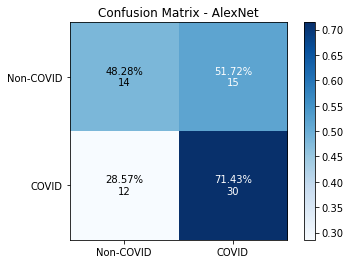

f1 score is : 0.689655172413793
AUC score is  0.6888341543513956


In [120]:
y_label, y_pred, outputs, inputs =  get_eval_results(model_1, test_loader)
plot_confusion_matrix(y_label, y_pred, 'Confusion Matrix - AlexNet')
print("f1 score is :", f1_score(y_label, y_pred))
print("AUC score is ", roc_auc_score(y_label, outputs[:, 1]))

In [127]:
test_acc, test_f1, test_auc = [], [], []

for i in range(2):
    model_1, input_size = initialize_model(model_name = 'squeezenet', num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)
    model_1 = model_1.to(device)

    optimizer_1 = make_optimizer(model_1, learning_rate)
    trained_model_1, validation_history_1, train_history_1 = train_model(model_1, optimizer_1, num_epochs)

    # Load your final model, that we will use for the rest of the PSET.
    if early_stopping:
        weights_file = '' + 'weights_best_val_acc.pt'
    else:
        weights_file = '' + 'weights_last.pt'

    model_1, _ = initialize_model(model_name = 'squeezenet', num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)

    # Move the model to the gpu if needed
    model_1 = model_1.to(device)

    # Load weights for model_yours
    model_1.load_state_dict(torch.load(weights_file))

    # Get data on the validation set

    val_loss_yours, val_top1_yours, _, val_labels_yours = evaluate(model_1, val_loader, is_labelled = True, generate_labels = True, k = 1)
    # Get predictions for the test set
    test_loss_yours, test_top1_yours, _, test_labels_yours = evaluate(model_1, test_loader, is_labelled = True, generate_labels = True, k = 1)

    test_acc.append(test_top1_yours)

    print("Our Trained model: ")
    print("Val Top-1 Accuracy: {}".format(val_top1_yours))
    print("Test Top-1 Accuracy: {}".format(test_top1_yours))

    y_label, y_pred, outputs, inputs =  get_eval_results(model_1, test_loader)
    test_f1.append(f1_score(y_label, y_pred))
    test_auc.append(roc_auc_score(y_label, outputs[:, 1]))

    print("f1 score is :", f1_score(y_label, y_pred))
    print("AUC score is ", roc_auc_score(y_label, outputs[:, 1]))

Epoch 1/20
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


train Loss: 0.7001 Acc: 0.5346
val Loss: 0.6931 Acc: 0.4161
Epoch 2/20
----------
train Loss: 0.6930 Acc: 0.5280
val Loss: 0.6931 Acc: 0.4161
Epoch 3/20
----------
train Loss: 0.6915 Acc: 0.5137
val Loss: 0.6931 Acc: 0.4161
Epoch 4/20
----------
train Loss: 0.6932 Acc: 0.4946
val Loss: 0.6931 Acc: 0.4161
Epoch 5/20
----------
train Loss: 0.6932 Acc: 0.4923
val Loss: 0.6931 Acc: 0.4161
Epoch 6/20
----------
train Loss: 0.6931 Acc: 0.4976
val Loss: 0.6931 Acc: 0.4161
Epoch 7/20
----------
train Loss: 0.6931 Acc: 0.4994
val Loss: 0.6931 Acc: 0.4161
Epoch 8/20
----------
train Loss: 0.6932 Acc: 0.4976
val Loss: 0.6931 Acc: 0.4161
Epoch 9/20
----------
train Loss: 0.6931 Acc: 0.5006
val Loss: 0.6931 Acc: 0.4161
Epoch 10/20
----------
train Loss: 0.6931 Acc: 0.4976
val Loss: 0.6931 Acc: 0.4161
Epoch 11/20
----------
train Loss: 0.6932 Acc: 0.4952
val Loss: 0.6931 Acc: 0.4161
Epoch 12/20
----------
train Loss: 0.6931 Acc: 0.5036
val Loss: 0.6931 Acc: 0.4161
Epoch 13/20
----------
train Loss: 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


train Loss: 0.6983 Acc: 0.5048
val Loss: 0.6931 Acc: 0.4161
Epoch 2/20
----------
train Loss: 0.6932 Acc: 0.5048
val Loss: 0.6931 Acc: 0.4161
Epoch 3/20
----------
train Loss: 0.6932 Acc: 0.4970
val Loss: 0.6931 Acc: 0.4161
Epoch 4/20
----------
train Loss: 0.6931 Acc: 0.5042
val Loss: 0.6931 Acc: 0.4161
Epoch 5/20
----------
train Loss: 0.6932 Acc: 0.5125
val Loss: 0.6931 Acc: 0.4161
Epoch 6/20
----------
train Loss: 0.6931 Acc: 0.4958
val Loss: 0.6931 Acc: 0.4161
Epoch 7/20
----------
train Loss: 0.6931 Acc: 0.4976
val Loss: 0.6931 Acc: 0.4161
Epoch 8/20
----------
train Loss: 0.6950 Acc: 0.5149
val Loss: 0.6931 Acc: 0.4161
Epoch 9/20
----------
train Loss: 0.6931 Acc: 0.4785
val Loss: 0.6931 Acc: 0.4161
Epoch 10/20
----------
train Loss: 0.6934 Acc: 0.4970
val Loss: 0.6931 Acc: 0.4161
Epoch 11/20
----------
train Loss: 0.6931 Acc: 0.4654
val Loss: 0.6931 Acc: 0.4161
Epoch 12/20
----------
train Loss: 0.6932 Acc: 0.4994
val Loss: 0.6931 Acc: 0.4161
Epoch 13/20
----------
train Loss: 

In [128]:
print(np.mean(test_acc), np.std(test_acc))
print(np.mean(test_f1), np.std(test_f1))
print(np.mean(test_auc), np.std(test_auc))

0.4084507042253521 0.0
0.0 0.0
0.5 0.0


In [124]:
model_1, input_size = initialize_model(model_name = 'squeezenet', num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)
model_1 = model_1.to(device)

optimizer_1 = make_optimizer(model_1, learning_rate)
trained_model_1, validation_history_1, train_history_1 = train_model(model_1, optimizer_1, num_epochs)

Epoch 1/20
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


train Loss: 0.6286 Acc: 0.6377
val Loss: 0.6922 Acc: 0.4362
Epoch 2/20
----------
train Loss: 0.6543 Acc: 0.5900
val Loss: 0.7065 Acc: 0.4161
Epoch 3/20
----------
train Loss: 0.6878 Acc: 0.5250
val Loss: 0.6931 Acc: 0.4161
Epoch 4/20
----------
train Loss: 0.6931 Acc: 0.4958
val Loss: 0.6931 Acc: 0.4161
Epoch 5/20
----------
train Loss: 0.6932 Acc: 0.4881
val Loss: 0.6931 Acc: 0.4161
Epoch 6/20
----------
train Loss: 0.6928 Acc: 0.5030
val Loss: 0.6933 Acc: 0.4161
Epoch 7/20
----------
train Loss: 0.6918 Acc: 0.5232
val Loss: 0.6932 Acc: 0.4362
Epoch 8/20
----------
train Loss: 0.6774 Acc: 0.5685
val Loss: 0.6931 Acc: 0.4161
Epoch 9/20
----------
train Loss: 0.6931 Acc: 0.5036
val Loss: 0.6931 Acc: 0.4161
Epoch 10/20
----------
train Loss: 0.6932 Acc: 0.5119
val Loss: 0.6931 Acc: 0.4161
Epoch 11/20
----------
train Loss: 0.6926 Acc: 0.5232
val Loss: 0.6932 Acc: 0.4631
Epoch 12/20
----------
train Loss: 0.6925 Acc: 0.5209
val Loss: 0.6929 Acc: 0.4631
Epoch 13/20
----------
train Loss: 

In [125]:
# Load your final model, that we will use for the rest of the PSET.
if early_stopping:
    weights_file = '' + 'weights_best_val_acc.pt'
else:
    weights_file = '' + 'weights_last.pt'

model_1, _ = initialize_model(model_name = 'squeezenet', num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)

# Move the model to the gpu if needed
model_1 = model_1.to(device)

# Load weights for model_yours
model_1.load_state_dict(torch.load(weights_file))

<All keys matched successfully>

In [126]:
# Get data on the validation set

val_loss_yours, val_top1_yours, _, val_labels_yours = evaluate(model_1, val_loader, is_labelled = True, generate_labels = True, k = 1)
# Get predictions for the test set
test_loss_yours, test_top1_yours, _, test_labels_yours = evaluate(model_1, test_loader, is_labelled = True, generate_labels = True, k = 1)

print("Our Trained model: ")
print("Val Top-1 Accuracy: {}".format(val_top1_yours))
print("Test Top-1 Accuracy: {}".format(test_top1_yours))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Our Trained model: 
Val Top-1 Accuracy: 0.5436241610738255
Test Top-1 Accuracy: 0.5070422535211268
